## **«Предварительный анализ данных и построение признаков в задачах распознавания эмоций в тексте»**

**Цель**: Произвести классификацию текстовых данных по классам-эмоциям при помощи инструментов машинного обучения.

**Задачи:**
* Реализовать анализ имеющегося набора данных
* Произвести обработку естественного языка
* Выявить наилучшую модель классификации с наиболее высокими показателями качества обучения модели

**Ожидаемый результат** -- создание модели, которая сможет распознавать эмоциональный окрас текстов.

**План работы:**
*   Загрузка и описание датасета
*   Предварительный анализ и очистка данных
*   Обработка естественного языка
*   Преобразование текстовых данных в числовые. Векторизация текста
*   Построение моделей классификации
*   Сравнение моделей
*   Улучшение модели
*   Заключение


# Загрузка и описание датасета

## Импорт библиотек

In [ ]:
# Импортируем необходимые для работы библиотеки

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# обработка естественного языка
from gensim.parsing.preprocessing import remove_stopwords
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# векторизация текста
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing

# модели машинного обучения
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import RidgeClassifierCV

# метрики точности моделей
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

## Описание данных

Загрузим датасет и выведем первые строки, чтобы посмотреть на его содержимое и изучить данные

In [ ]:
data = pd.read_csv('tweet_emotions.csv')   # загрузка датасета
data.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
data.shape    #размерность датасета

(40000, 3)

Датасет содержит $ 40000 $ строк и $ 3 $ столбца

In [ ]:
data.dtypes

tweet_id      int64
sentiment    object
content      object
dtype: object

Датасет сожержит $1$ числовой столбец (количественный признак) и $2$ нечисловых (категориальные признаки)




In [ ]:
data.columns   # наименования столбцов

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

Столбцы:

*   ```tweet_id```-- id каждого пользователя, оставившего сооющение в твиттере
*  ```sentiment```	-- целевой столбец, определяющий эмоцию в тексте столбца content
*   ```content  ```-- текст-сообщение пользовател в твиттере, у которого необходимо распознать эмоцию


In [ ]:
len(data['sentiment'].unique())
# количество уникальных значений в столбце с эмоциями

13

В столбце ```sentiment``` сожержится 13 уникальных значений => имеется $13$ классов эмоций, по которым предстоит проклассифицировать текст

>**Решаемая проблема** -- множество объектов текста разделить на $ 13 $ классов эмоций (**задача классификации текста**), проведя предварительно обработку естественного языка. Задача классификации относится к задачам обучения с учителем, поскольку нам заранее известен результат, который мы хотим получить.

# Предварительный анализ и очистка данных

Для построения более точных и качественных моделей изучим и проанализируем сиходные данные

In [ ]:
data.describe()   # описательная статистика, основная статистическая информация об атрибутах (по столбцу tweet_id, тк только он сожержит числовые данные)

,tweet_id
count,4.000000e+04
mean,1.845184e+09
std,1.188579e+08
min,1.693956e+09
25%,1.751431e+09
50%,1.855443e+09
75%,1.962781e+09
max,1.966441e+09


Столбец ```tweet_id``` представляет количественную харкатеристику датасета

In [ ]:
data[['sentiment']].describe()

,sentiment
count,40000
unique,13
top,neutral
freq,8638


In [ ]:
 data[['content']].describe()

,content
count,40000
unique,39827
top,I just received a mothers day card from my lov...
freq,14


>Столбцы ```sentiment``` и ```content``` являются категориальными признаками

---
**Значимость каждого из атрибутов для предсказания целевой переменной**


*   ```tweet_id``` является лишь идентификатором пользователя, оставившего текст. Данный атрибут не оказывает влияния на целевую переменную ```sentiment```, поскольку нам не важно кто оставил текст, а важно лишь содержимое текста для дальнейшей классификации текстов
*   ```content``` вкслючает в себя текст, который необходимо проклассифицировать по классам $=>$ оказывает влияние на целевую переменную ```sentiment```

##Очистка данных

Просмотрим датасет на наличие:
* отсутствующих данных;
* неинформативных данных – дубликатов;
* несогласованных данных – одних и тех же данных, представленных в разных регистрах или форматах.

> Проверка датасета на наличие пустых значений:

In [ ]:
data.info()   # типы данных, кол-во значений в каждом столбце, тип данных каждого столбца

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [ ]:
data.isnull().sum()    # количество пропущенных значений

tweet_id     0
sentiment    0
content      0
dtype: int64

Датасет не содержит пустых (пропущенных) значений => не требует очистки

In [ ]:
print(f'''Max length --> {data['content'].str.len().max()},
Mean length --> {data['content'].str.len().mean()},
Min length --> {data['content'].str.len().min()}''')   # максимальная, средняя и минимальная длина текста в датасете в поле content

Max length --> 167,    
Mean length --> 73.40555, 
Min length --> 1


Максимальная длина текстового сообщения $167$, средняя ~ $73$, минимальная -- $1$ символ\
Датасет содержит несколько записей, состоящих из $1$ символа.\
Посмотрим на содержимое данных строк. При отсутсвии смысловой значимости данных удалим эти строки из датасета

In [ ]:
data[data['content'].str.len() == 1]    # строки, длина которых = 1

,tweet_id,sentiment,content
340,1957042734,empty,0
15028,1964712204,neutral,0
29869,1751394197,neutral,0
39415,1753819910,neutral,0


Содержимое данных строк $= 0$. Данные записи можно удалить из датасета, поскольку их наличие не имеет смысла для дальнейшей классификации

In [ ]:
drop_index = data[data['content'].str.len() == 1].index; drop_index   # индексы строк, сотсоящих из 0, для удаления

Int64Index([340, 15028, 29869, 39415], dtype='int64')

In [ ]:
data = data.drop(labels =drop_index, axis = 0); data.head()   # удаление строк по индексам

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [ ]:
data['content'].str.len().min(), data[data['content'].str.len() == 1]

(6,
 Empty DataFrame
 Columns: [tweet_id, sentiment, content]
 Index: [])

In [ ]:
data.shape

(39996, 3)

Теперь минимальная длина текстового сообщения $= 6$, столбец больше не содержит записей, содержащих "0".\
Из датасета удалили $4$ строки, поэтому теперь количество строк стало $39996$

> Проверим датасет на наличие неинформативных данных - дубликатов в строках\
Значения столбца ```tweet_id``` не будем учитывать, поскольку его значения всегда уникальны и требуется проверить на дубликаты именно текст пользователй

In [ ]:
uniq_counts = pd.DataFrame(
    {
        'tweet_id': len(data['tweet_id'].unique()),
        'sentiment': len(data['sentiment'].unique()),
        'content': len(data['content'].unique()),
    }, index = ['value counts']
)
uniq_counts

,tweet_id,sentiment,content
value counts,39996,13,39826


Можем сделать выввод, что:
*   Каждый ```	tweet_id``` уникален
*   Датафрейм содержит $13$ классов эмоций
* В столбце ```content``` содержатся дубликаты текста, тк количество уникальных значений не равно количествуву строк в датафрейме


In [ ]:
data[['sentiment','content']].duplicated().sum() # проверка на наличие дубликатов строк для столбцов эмоция - текст

89

Датасет содержит дубликаты строк (в количестве $89$), которые нужно удалить\
Но для начала просмотрим не имеется ли одинаковых записей в разных регистрах\
Для этого приведем все записи в единому регистру и повторно проверм на наличие дубликатов

In [ ]:
# принудительное понижение регистра
data['content'] = data['content'].str.lower()
data[['sentiment','content']].duplicated().sum() # проверка на наличие дубликатов строк для столбцов эмоция - текст

134

Количество дубликатов строк увеличилось. Датасет содержит дубликаты строк (в количестве $134$), которые нужно удалить из датасета

In [ ]:
data[data[['sentiment','content']].duplicated() == True]   # строки с дубликатами

,tweet_id,sentiment,content
521,1957088574,worry,somebody please save the polar bears!
6591,1961366316,sadness,headache
6718,1961422696,sadness,headache
8878,1962332251,worry,my throat hurts
9613,1962653254,worry,my tummy hurts
...,...,...,...
39859,1753886681,love,happy mothers day
39898,1753902524,love,happy mothers day!
39913,1753902827,happiness,happy mother's day!
39915,1753903008,love,happy mother's day everyone


In [ ]:
drop_index = data[data[['sentiment','content']].duplicated() == True].index   # индексы строк для удаления
drop_index

Int64Index([  521,  6591,  6718,  8878,  9613, 10918, 11800, 12531, 13491,
            14208,
            ...
            39260, 39277, 39284, 39600, 39772, 39859, 39898, 39913, 39915,
            39945],
           dtype='int64', length=134)

In [ ]:
data = data.drop(labels =drop_index, axis = 0); data.head()   # удаление строк

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends soon!
4,1956968416,neutral,@dannycastillo we want to trade with someone w...


In [ ]:
data[['sentiment','content']].duplicated().sum() # проверка на наличие дубликатов

0

Все дублирующиеся строки были удалены\
Теперь датасет не содержит дублирующихся строк по столбцам ```sentiment - content```

In [ ]:
data.shape   # теперь в датасете содержится 39862 записи

(39862, 3)

## Анализ данных


Опрделим, какое количество строк (сколько текстов) относятся к каждому классу эмоций\
Для этого сгруппируем датасет по столбцу ```sentiment```

In [ ]:
(data.groupby(['sentiment']))['content'].count()   # соотношение эмоция - кол-во текстов к эмоции

sentiment
anger          110
boredom        179
empty          826
enthusiasm     759
fun           1776
happiness     5183
hate          1323
love          3787
neutral       8606
relief        1524
sadness       5155
surprise      2186
worry         8448
Name: content, dtype: int64

Визуализация и наглядное представление распрделения эмоций. Гистограмма показывает распределение того, как часто в датасете встречается каждая из эмоций (какое количество раз)

(array([ 826., 5155.,  759., 8606., 8448., 2186., 3787., 1776., 1323.,
        5183.,  179., 1524.,  110.]),
 array([ 0.        ,  0.92307692,  1.84615385,  2.76923077,  3.69230769,
         4.61538462,  5.53846154,  6.46153846,  7.38461538,  8.30769231,
         9.23076923, 10.15384615, 11.07692308, 12.        ]),
 <BarContainer object of 13 artists>)

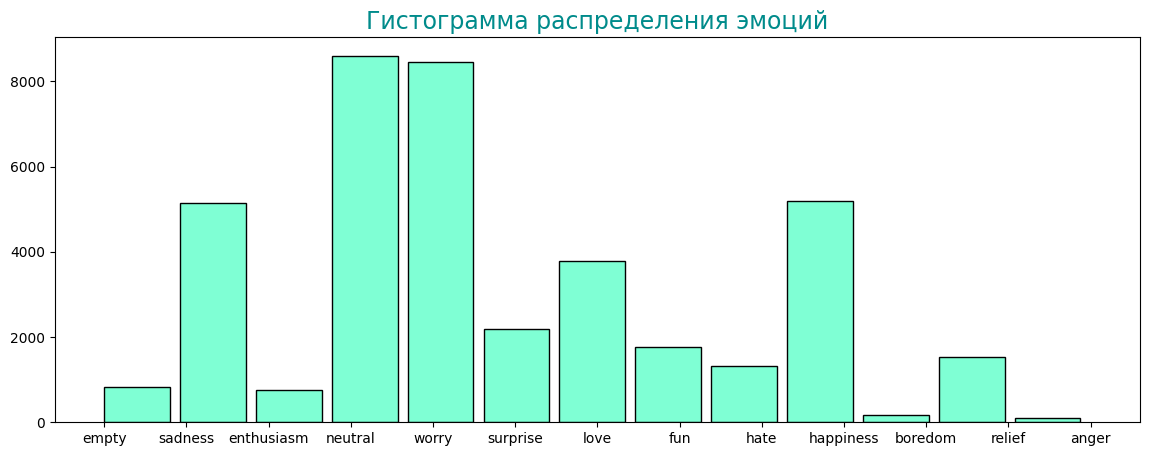

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,5))  # создание рабочей области

ax.set_title('Гистограмма распределения эмоций', color = 'darkcyan', size = 17)   # названия графика
ax.hist(
    data['sentiment'],
    edgecolor = 'black',  # обводка колонок
    color ='aquamarine',
    bins = 13,   # кол-во колонок
    width  = 0.8   # ширина колонок
    )

>Наиболее часто встречается класс ```neutral	```\
Самый редкий - ```anger```\
Можно сделать вывод о *несбалансированности* набора данных, тк некоторые классы представлены значительно меньшим количеством данных

In [ ]:
frequency = data['sentiment'].value_counts(normalize = True); frequency   # относительная частота каждого класса

neutral       0.215895
worry         0.211931
happiness     0.130024
sadness       0.129321
love          0.095003
surprise      0.054839
fun           0.044554
relief        0.038232
hate          0.033190
empty         0.020721
enthusiasm    0.019041
boredom       0.004490
anger         0.002760
Name: sentiment, dtype: float64

In [ ]:
frequency.index

Index(['neutral', 'worry', 'happiness', 'sadness', 'love', 'surprise', 'fun',
       'relief', 'hate', 'empty', 'enthusiasm', 'boredom', 'anger'],
      dtype='object')

[Text(0, 0, '0.215895'),
 Text(0, 0, '0.211931'),
 Text(0, 0, '0.130024'),
 Text(0, 0, '0.129321'),
 Text(0, 0, '0.0950028'),
 Text(0, 0, '0.0548392'),
 Text(0, 0, '0.0445537'),
 Text(0, 0, '0.0382319'),
 Text(0, 0, '0.0331895'),
 Text(0, 0, '0.0207215'),
 Text(0, 0, '0.0190407'),
 Text(0, 0, '0.00449049'),
 Text(0, 0, '0.00275952')]

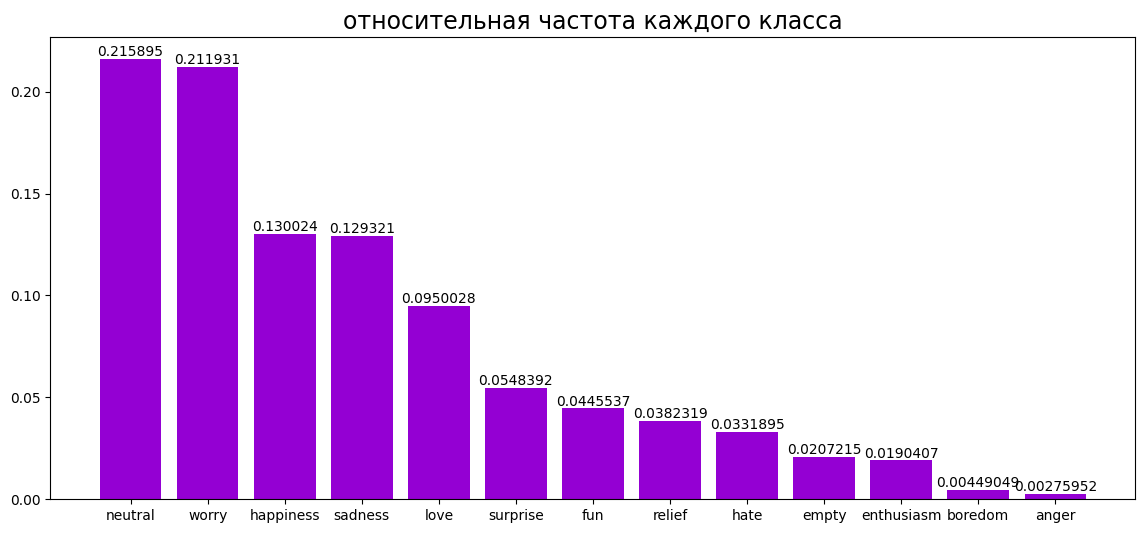

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,6))  # создание рабочей области

ax.set_title('относительная частота каждого класса', color = 'black', size = 17)   # названия графика
ax.bar(frequency.index, frequency, color = 'darkviolet')

ax.bar_label(ax.containers[0], label_type='edge')

Вычисление относительной частоты показало аналогичные результаты

---

Проанализируем поле ```content``` по длине символов





In [ ]:
text_length = data['content'].str.len(); text_length    #длина каждого текстового сообщения

0         92
1         60
2         35
3         36
4         86
        ... 
39995     16
39996     30
39997    123
39998    122
39999    132
Name: content, Length: 39862, dtype: int64

In [ ]:
text_length.describe()   # описательная статистика

count    39862.000000
mean        73.535021
std         36.492918
min          6.000000
25%         43.000000
50%         69.000000
75%        103.000000
max        167.000000
Name: content, dtype: float64

Максимальное значение длины текста $= 167$, медианное значение $= 73$. Это говорит о том, что в наборе данных присутствует незначительная асимметрия

<Axes: >

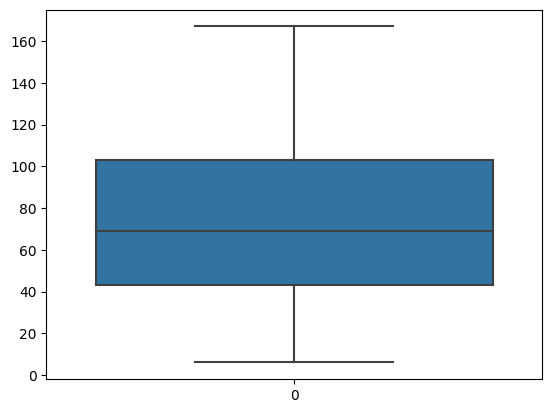

In [ ]:
sns.boxplot(text_length)

На графике видно, что максимальное значение чуть больше $160$, минимальное ~ $6$,среднее значение колеблется около $70$. Выбросов (сильно выбивающихся значений) не имеется

Посмотрим среднее количество слов текста для каждой категории

In [ ]:
words = data['content'].apply(lambda x: len(x.split())); words   # количество слов в каждой строке поля сontent

0        18
1        10
2         3
3         7
4        15
         ..
39995     1
39996     6
39997    25
39998    19
39999    18
Name: content, Length: 39862, dtype: int64

In [ ]:
new_data = data.copy()
new_data['content'] = words
new_data.head()   # новый датасет, у которого текст заменен на количество слов в тексте

,tweet_id,sentiment,content
0,1956967341,empty,18
1,1956967666,sadness,10
2,1956967696,sadness,3
3,1956967789,enthusiasm,7
4,1956968416,neutral,15


In [ ]:
mean_word = pd.DataFrame(new_data.groupby(['sentiment'])['content'].mean()); mean_word    # среднее значение количества слов в тексте для каждой категории

,content
sentiment,
anger,14.100000
boredom,13.603352
empty,11.473366
enthusiasm,13.426877
fun,14.390203
happiness,13.410380
hate,14.360544
love,13.303670
neutral,11.370788


[Text(0, 0, '14.1'),
 Text(0, 0, '13.6034'),
 Text(0, 0, '11.4734'),
 Text(0, 0, '13.4269'),
 Text(0, 0, '14.3902'),
 Text(0, 0, '13.4104'),
 Text(0, 0, '14.3605'),
 Text(0, 0, '13.3037'),
 Text(0, 0, '11.3708'),
 Text(0, 0, '13.8445'),
 Text(0, 0, '13.9133'),
 Text(0, 0, '13.5403'),
 Text(0, 0, '14.1446')]

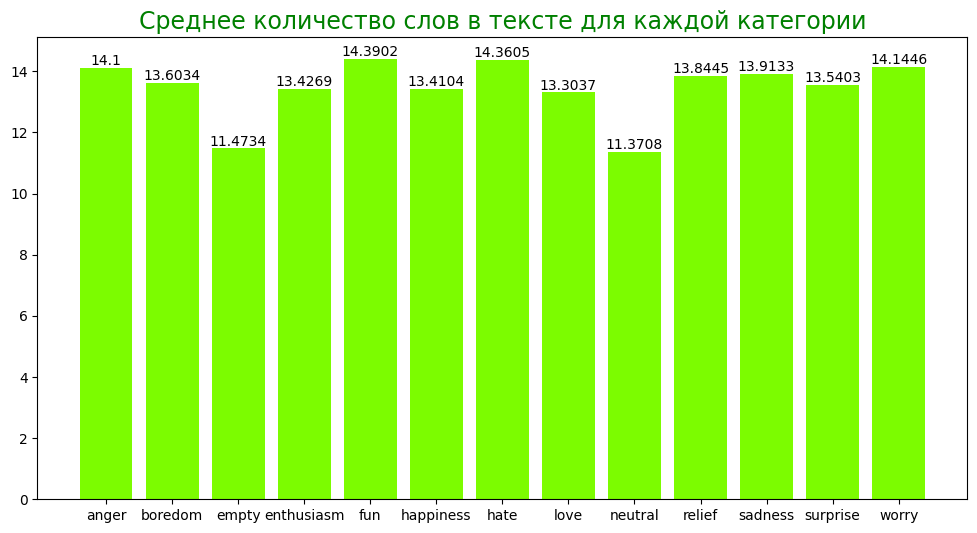

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (12,6))  # создание рабочей области

ax.set_title('Среднее количество слов в тексте для каждой категории', color = 'green', size = 17)   # названия графика
ax.bar(mean_word.index,mean_word['content'], color = 'lawngreen')

ax.bar_label(ax.containers[0], label_type='edge')

In [ ]:
mean_word['content'].mean(), mean_word['content'].max(), mean_word['content'].min()    # среднее значение слов в тексте для всего датасета

(13.452450952455308, 14.390202702702704, 11.370787822449454)

В среднем каждый текст состоит из $13-14$ слов\
Самое большое среднее количество слов у категории ```fun```, меньше всего слов в среднем у категории ```neutral```

## Разделение переменных


Разделим переменные на целевую $y$ и факторы $X$\
$y$ -- зависимая от $X$ переменная

Получим единственный фактор $X$, оказывающий влияние на $y$


In [ ]:
Y = pd.DataFrame(data['sentiment'])
X = pd.DataFrame(data['content'])
X.head()

,content
0,@tiffanylue i know i was listenin to bad habi...
1,layin n bed with a headache ughhhh...waitin o...
2,funeral ceremony...gloomy friday...
3,wants to hang out with friends soon!
4,@dannycastillo we want to trade with someone w...


In [ ]:
Y.head()    # целевая переменная

,sentiment
0,empty
1,sadness
2,sadness
3,enthusiasm
4,neutral


В итоге получается $1$ фактор $X$, оказывающий влияние на целевую переменную $y$

In [ ]:
Y['sentiment'].unique()    # все классы эмоций

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [ ]:
len(Y['sentiment'].unique())
# классификация на 13 классов эмоций

13

# Обработка естественного языка

> Для получения более качественных моделей и получения более точных результатов необходимо обработать текстовые данные.

Для этого:
* Удалим стоп-слова из датасета;
* Избавимся от чисел, знаков препинания и всех ненужных (незначимых) символов
* Разобьем текст на токены (токенизация);
* Проведем лемматизацию, получив нормальную (начальную) форму слова;
* Построим облако слов;

##Удаление стоп-слов





> Для начала почистим датасет от стоп-слов, которые в естественном языке не несут смысловой нагрузки и не влияют на классификацию машинного обучения. Стоп-слова игнорируются, чтобы выдать более точные результаты.

In [ ]:
X.head()   # для наглядного сравнения

,content
0,@tiffanylue i know i was listenin to bad habi...
1,layin n bed with a headache ughhhh...waitin o...
2,funeral ceremony...gloomy friday...
3,wants to hang out with friends soon!
4,@dannycastillo we want to trade with someone w...


In [ ]:
X = pd.DataFrame(X['content'].apply(lambda x: remove_stopwords(x))); X.head()   # удаление стоп-слов

,content
0,@tiffanylue know listenin bad habit earlier st...
1,layin n bed headache ughhhh...waitin call...
2,funeral ceremony...gloomy friday...
3,wants hang friends soon!
4,"@dannycastillo want trade houston tickets, will."


Видно, что из датасета удалились стоп-слова, такие как "$i","to","we", "was","with"$ и тд. Это упростит процесс обучения и классификации модели

## Очистка от неалфавитных символов

Twitter использует разметку твитов с помощью “www”, “#” и “@”. Для более правильной классификации эмоций, необходимо предварительно обработать текст, чтобы нормализовать язык.

Большинство твиттов -- это ответы на твитты других пользователей, поэтому они начинаются с ```@```, после чего следует имя пользователя, которому идет ответ

In [ ]:
X['content'].str.startswith('@').sum()    # теги пользователей

18144

In [ ]:
X['content'].str.startswith('#').sum()    # хештеги

107

In [ ]:
X['content'].str.startswith('www').sum()   # ссылки на сайт

3

In [ ]:
X['content'].str.startswith('https').sum()   # ссылки на сайт

0

* $18144$ твиттов начинаются с символа @, что означает ответ другому пользователю\
После символа @ следует имя пользователя. Для нас оно не важно для классификации и является лишней информацией в текстовом сообщении, поэтому все никнеймы можно удалить

* $107$ твиттов начинаются с символа ```#```, после чего идет определенный тег
* $3$ твитта начинаются с ```www```, то есть идет ссылка на сайт. Сайт также не представляет эмоцию

In [ ]:
X.head()   # для наглядного сравнения

,content
0,@tiffanylue know listenin bad habit earlier st...
1,layin n bed headache ughhhh...waitin call...
2,funeral ceremony...gloomy friday...
3,wants hang friends soon!
4,"@dannycastillo want trade houston tickets, will."


In [ ]:
# Функция re.sub позволяет заменить все, что подходит под шаблон на указанную строку.


X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"@\w+\s?"," ",x))); X.head()
# удаляет все слова, начинающиеся на @
# \w — заменяет любую цифру, букву, а также _
# \s — соответствует любому пробельному символу;
# "?" означает, что после слова может следовать необязательный пробел

,content
0,know listenin bad habit earlier started freak...
1,layin n bed headache ughhhh...waitin call...
2,funeral ceremony...gloomy friday...
3,wants hang friends soon!
4,"want trade houston tickets, will."


In [ ]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"@\s+\w?"," ",x)))
# сначала идет @, после нее пробел, а потом тег (@ name)

Данный код позволяет удалить из текста все упоминания пользователей в социальных сетях, которые начинаются с символа "@".

Удаляем все сообщение, начинающиеся с хэштегов

In [ ]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"#\w+\s?"," ",x)))   # без пробельного символа: #tag
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"#\s+\w?"," ",x)))   # пробельный символ после хэштега: # tag

Удаляем все неалфавитные символы

In [ ]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub(r"[^a-z\s\(\-:\)\\\/\];='#]"," ",x)))
# ^ - любой символ кроме перечисленных(то есть не буква алфавита)
# \s - любой пробельный символ
# удаляет любой символ из (\-:\)\\\/\];='#]

Удаляем все сообщения, содержашие ссылку на сайт

In [ ]:
X = pd.DataFrame(X['content'].apply(lambda x: re.sub('www.\w+\s'," ",x)))
X = pd.DataFrame(X['content'].apply(lambda x: re.sub('www.\s+\w'," ",x)))
# re.sub(r'www\.[a-z]?\.?(com)+|[a-z]+\.(com)', '', clean_text)

Убедимся в корректности удаления данных

In [ ]:
X['content'].str.startswith('@').sum(), X['content'].str.startswith('#').sum(), X['content'].str.startswith('www').sum()

(0, 0, 0)

Теперь датасет не содержит тегов пользователей, хэштегов и ссылок на сайт

## Токенизация текста

> Для того, чтобы осуществить лемматизацию предварительно проведем токенизацию текста -- разбиение на более мелкие фрагменты (слова)

In [ ]:
nltk.download('punkt')

X = pd.DataFrame(X['content'].apply(lambda x: word_tokenize(x))); X.head()   # разбивает текст на отдельные слова по пробелам в список

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,content
0,"[know, listenin, bad, habit, earlier, started,..."
1,"[layin, n, bed, headache, ughhhh, waitin, call]"
2,"[funeral, ceremony, gloomy, friday]"
3,"[wants, hang, friends, soon]"
4,"[want, trade, houston, tickets, will]"


## **Лемматизация текста**

> Лемматизация является процессом приведения слова к его основной форме. Это позволяет упростить обработку естественного языка и улучшить качество анализа текстов.

In [ ]:
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()   # объект класса
X = pd.DataFrame(X['content'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x]))); X.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content
0,know listenin bad habit earlier started freakin =
1,layin n bed headache ughhhh waitin call
2,funeral ceremony gloomy friday
3,want hang friend soon
4,want trade houston ticket will


Посмотрим как изменилось среднее количество слов в наборе данных

In [ ]:
words = X['content'].apply(lambda x: len(x.split())); words   # количество слов в каждой строке поля сontent

0         8
1         7
2         4
3         4
4         5
         ..
39995     0
39996     4
39997    14
39998    13
39999    10
Name: content, Length: 39862, dtype: int64

In [ ]:
X_word = X.copy()
X_word['content'] = words
X_word.head()   # новый датасет, у которого текст заменен на количество слов в тексте

,content
0,8
1,7
2,4
3,4
4,5


In [ ]:
mean_word = pd.DataFrame(X_word.mean()); mean_word    # среднее значение количества слов в тексте для каждой категории

,0
content,7.843335


В среднем текст содержит теперь по 8 слов

## Облако слов

>Визуализация популярности слов в виде облака, которое  показывает самые частовстречающиеся слова текста

Text(0.5, 1.0, 'Облако слов')

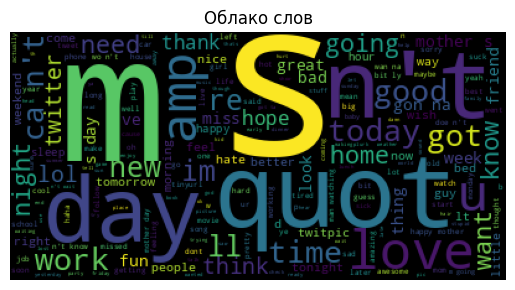

In [ ]:
text = "".join(X['content'])

cloud = WordCloud().generate(text)    # генерация облака слов
plt.imshow(cloud)
plt.axis('off')   # убирает разметку (шкалу измерения) у осей
plt.title('Облако слов')

# Преобразование текстовых данных в числовые. Векторизация текста

 Алгоритмы машинного обучения не умеют работать с текстом, поэтому для дальнейшей классификации необходимо представить текстовые данные числами. Для этого потребуется преобразовать столбцы ```content``` и ```sentiment```

## Разделение данных на тестовую и обучающую выборки

>Предварительно разделим набор данных на тестовую и обучащиеся выборки для того, чтобы в будущем при обучении моделей более точно оценить качество модели и снизить риск пере- или недо обучения модели.\
Из выборки данных отделим часть данных на обучение, оставшаяся часть данных будет использоваться для оценки качества

In [ ]:
x = X['content'].values
y = Y['sentiment'].values
x, y   # получение значений, каждое предложение/категория отдельным элементом списка

(array(['know listenin bad habit earlier started freakin =',
        'layin n bed headache ughhhh waitin call',
        'funeral ceremony gloomy friday', ...,
        "happy mother 's day mommy there woman man long you 're 'momma ' day",
        'wassup beautiful follow me peep new hit single com/ipsohot def wat u video',
        'bullet train tokyo gf visiting japan thursday vacation/sightseeing gaijin godzilla'],
       dtype=object),
 array(['empty', 'sadness', 'sadness', ..., 'love', 'happiness', 'love'],
       dtype=object))

Поскольку мы имеем всего 13 уникальных классов для переменной $y$, можно произвести кодирование целевой переменной при помощи ```LabelEncoder```, который преобразует каждую категорию в числа от $1$ до числа, равного количеству категорий (то есть до &13&). Применим его к целевой переменной.

In [ ]:
dict_emotion = {i: np.unique(y)[i] for i in range(13)}
dict_emotion    # словарь соотношения категории и его номера

{0: 'anger',
 1: 'boredom',
 2: 'empty',
 3: 'enthusiasm',
 4: 'fun',
 5: 'happiness',
 6: 'hate',
 7: 'love',
 8: 'neutral',
 9: 'relief',
 10: 'sadness',
 11: 'surprise',
 12: 'worry'}

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)    # всевозможные уникальные значения переменной y
y, encoder.classes_   # всевозможные уникальные значения y

(array([ 2, 10, 10, ...,  7,  5,  7]),
 array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
        'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
        'worry'], dtype=object))

In [ ]:
# произведем разбиение выборки на тестовую и обучающуюся

X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25, # проентная доля объема тестовой выборки от всего объема выборки
    random_state=42    # рандомное распределение данных по выборкам
    )

In [ ]:
X_train.shape, X_test.shape

((29896,), (9966,))

Модель обучается на $29896$ примерах, оставшиеся $9966$ идут на тестирование и оценку качества/производительности модели



Визаулизируем распределение тестовой и обучающейся выборки по категориям

In [ ]:
y_train_val = pd.DataFrame(y_train).value_counts().sort_index()
y_test_val = pd.DataFrame(y_test).value_counts().sort_index()
index = y_train_val.index
index = [dict_emotion[i] for i in range(13)]
y_train_val, y_test_val

(0       84
 1      139
 2      591
 3      574
 4     1345
 5     3879
 6      985
 7     2841
 8     6448
 9     1140
 10    3847
 11    1683
 12    6340
 dtype: int64,
 0       26
 1       40
 2      235
 3      185
 4      431
 5     1304
 6      338
 7      946
 8     2158
 9      384
 10    1308
 11     503
 12    2108
 dtype: int64)

[Text(0, 0, '26'),
 Text(0, 0, '40'),
 Text(0, 0, '235'),
 Text(0, 0, '185'),
 Text(0, 0, '431'),
 Text(0, 0, '1304'),
 Text(0, 0, '338'),
 Text(0, 0, '946'),
 Text(0, 0, '2158'),
 Text(0, 0, '384'),
 Text(0, 0, '1308'),
 Text(0, 0, '503'),
 Text(0, 0, '2108')]

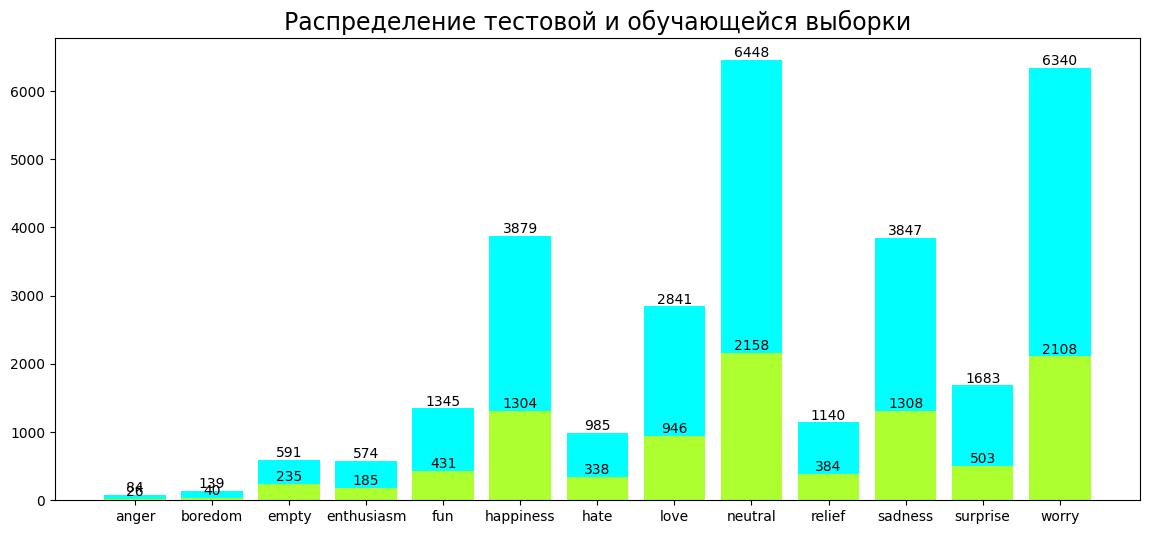

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (14,6))  # создание рабочей области

ax.set_title('Распределение тестовой и обучающейся выборки', color = 'black', size = 17)   # названия графика
ax.bar(index, y_train_val, color = 'cyan')
ax.bar(index, y_test_val, color = 'greenyellow')
ax.bar_label(ax.containers[0], label_type='edge')
ax.bar_label(ax.containers[1], label_type='edge')

## Векторизация текста





> Осуществим преобразование данных при помощи ```TfidfVectorizer```, который оценивает частоту появления как в отдельных фрагментах текста, так и во всем тексте,  а также при помощи ```CountVectorizer```, который  в матрицу количества токенов

In [ ]:
%%time

vectorizer = TfidfVectorizer()   # объект класса
x_train_tf = vectorizer.fit_transform(X_train).toarray()   # преобразование данных + обучение для обучaющихся данных
x_test_tf = vectorizer.transform(X_test).toarray()      # только преобразование для тестовых данных

CPU times: user 871 ms, sys: 1.8 s, total: 2.67 s
Wall time: 2.74 s


In [ ]:
%%time

vectorizer = CountVectorizer()   # объект класса
x_train_cv = vectorizer.fit_transform(X_train).toarray()   # преобразование данных + обучение для обучaющихся данных
x_test_cv = vectorizer.transform(X_test).toarray()      # только преобразование для тестовых данных

CPU times: user 462 ms, sys: 2.19 s, total: 2.65 s
Wall time: 2.66 s


In [ ]:
x_train_tf, x_test_cv    # представление текста в виде числовой матрицы

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]))

При обучении моделей будем применять данные, векторизированные обоими способами

# Построение моделей классификации

In [ ]:
# словарь со всеми полученными метриками точности для дальнейшего сравнения моделей

metrics = pd.DataFrame(columns = ['Logistic Regression', 'Random Forest', 'SVM', 'Neighbors', 'Tree', 'NB', 'Passive Agressive'],
                       index = ['accuracy_score','time', 'roc_auc', 'recall', 'precision'])

## Логистическая регрессия ```LogisticRegression```

> ```TfdifVectorizer```

In [ ]:
%%time

lr1 = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression(max_iter=500000, C = 1, solver = 'liblinear'))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
lr1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time, 2)
y_pred_tf = lr1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = lr1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 49.97%
Test score: 35.39%
Time fit: 2.22 s
CPU times: user 2.92 s, sys: 1.7 s, total: 4.62 s
Wall time: 2.81 s


На основе полученных результатов точностей моделей можно сделать вывод о недообучении модели, поскольку значение метрики точности обучающейся выборки довольно низкое. Модель делает верный прогноз с точностью ~35%

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.33      0.00      0.01       235
           3       0.00      0.00      0.00       185
           4       0.15      0.01      0.02       431
           5       0.34      0.34      0.34      1304
           6       0.41      0.12      0.19       338
           7       0.48      0.41      0.44       946
           8       0.34      0.58      0.43      2158
           9       0.39      0.02      0.04       384
          10       0.35      0.22      0.27      1308
          11       0.28      0.03      0.05       503
          12       0.34      0.52      0.41      2108

    accuracy                           0.35      9966
   macro avg       0.26      0.17      0.17      9966
weighted avg       0.34      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

lr2 = Pipeline([('cv', CountVectorizer()), ('lr', LogisticRegression(max_iter=500000, C = 0.5, solver = 'liblinear'))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
lr2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time, 2)
y_pred_cv = lr2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = lr2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 58.74%
Test score: 34.86%
Time fit: 3.51 s
CPU times: user 4.16 s, sys: 2.8 s, total: 6.96 s
Wall time: 3.94 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.15      0.03      0.06       431
           5       0.33      0.33      0.33      1304
           6       0.39      0.18      0.25       338
           7       0.45      0.41      0.43       946
           8       0.34      0.60      0.44      2158
           9       0.22      0.04      0.06       384
          10       0.34      0.24      0.28      1308
          11       0.17      0.04      0.06       503
          12       0.35      0.44      0.39      2108

    accuracy                           0.35      9966
   macro avg       0.21      0.18      0.18      9966
weighted avg       0.32      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Модель ```TfdifVectorizer``` показала результаты лучше\
Посмотрим на другие метрики для этой модели

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_tf, labels = [j for j in range(13)])[i]
    for i in range(13)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'anger': array([[9940,    0],
        [  26,    0]]),
 'boredom': array([[9926,    0],
        [  40,    0]]),
 'empty': array([[9729,    2],
        [ 234,    1]]),
 'enthusiasm': array([[9781,    0],
        [ 185,    0]]),
 'fun': array([[9513,   22],
        [ 427,    4]]),
 'happiness': array([[7818,  844],
        [ 861,  443]]),
 'hate': array([[9568,   60],
        [ 296,   42]]),
 'love': array([[8597,  423],
        [ 560,  386]]),
 'neutral': array([[5366, 2442],
        [ 902, 1256]]),
 'relief': array([[9568,   14],
        [ 375,    9]]),
 'sadness': array([[8142,  516],
        [1024,  284]]),
 'surprise': array([[9427,   36],
        [ 489,   14]]),
 'worry': array([[5778, 2080],
        [1020, 1088]])}

<Axes: >

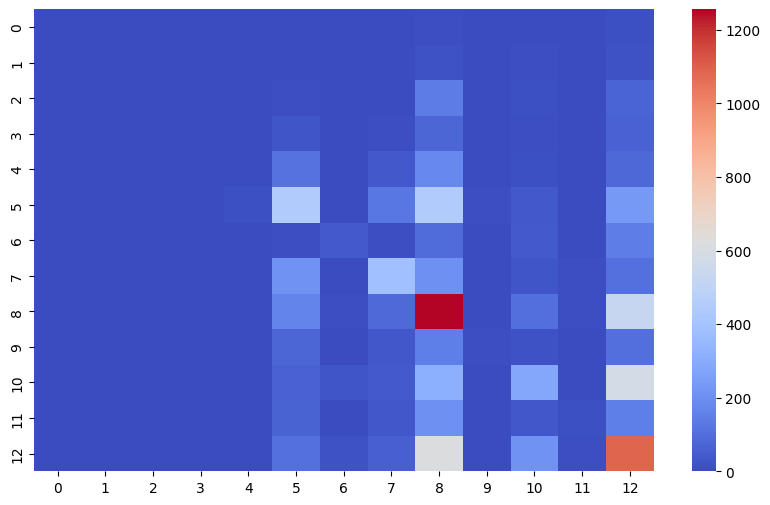

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_tf),cmap="coolwarm")

In [ ]:
# добавим лучшие показатели в таблицу сравнения

# модель TFIDF показали результаты лучше, поэтому добавляе ее значения метрик в итоговый датафрэйм
y_prob = lr1.predict_proba(X_test)
metrics['Logistic Regression']['accuracy_score'] = round(accuracy_score(y_test, y_pred_tf),4)*100   # заполнение датафрейма с метриками
metrics['Logistic Regression']['time'] =   time_fit_1 # заполнение датафрейма с метриками
metrics['Logistic Regression']['roc_auc'] = round(roc_auc_score(y_test, y_prob, multi_class="ovr"),2)
metrics['Logistic Regression']['recall'] = round(recall_score(y_test, y_pred_tf, average='weighted'),4)*100
metrics['Logistic Regression']['precision'] = round(precision_score(y_test, y_pred_tf, average='weighted'),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Сложность устройства данных выше, чем сложность устройства модели ```LogisticRegression```, поэтому модель недобучается. Построим более сложные модели

In [ ]:
metrics['Logistic Regression']

accuracy_score    35.39
time               2.22
roc_auc            0.69
recall            35.39
precision         34.08
Name: Logistic Regression, dtype: object

## Случайный лес ```RandomForest```

> ```TfdifVectorizer```

In [ ]:
%%time

rf1 = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier(random_state = 42))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
rf1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time,2)
y_pred_tf = rf1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = rf1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 98.05%
Test score: 34.22%
Time fit: 177.95 s
CPU times: user 3min 5s, sys: 468 ms, total: 3min 6s
Wall time: 3min 6s


Разница в показаниях тестовой и обучающейся выборок большая, то есть модель переобучилась

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.20      0.03      0.06       431
           5       0.31      0.33      0.32      1304
           6       0.37      0.17      0.23       338
           7       0.45      0.42      0.43       946
           8       0.33      0.56      0.42      2158
           9       0.21      0.03      0.05       384
          10       0.37      0.22      0.28      1308
          11       0.24      0.05      0.08       503
          12       0.34      0.47      0.39      2108

    accuracy                           0.34      9966
   macro avg       0.22      0.17      0.17      9966
weighted avg       0.32      0.34      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

rf2 = Pipeline([('cv', CountVectorizer()), ('rf', RandomForestClassifier(random_state = 42))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
rf2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time,2)
y_pred_cv = rf2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = rf2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 98.06%
Test score: 31.879999999999995%
Time fit: 193.86 s
CPU times: user 3min 21s, sys: 564 ms, total: 3min 22s
Wall time: 3min 21s


Наблюдается значительная разница между результатами тестовой и обучающейся выборок $=>$ модель тоже переобучилась

Результаты ```TfidfVectorizer``` оказались лучше

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_tf, labels = [j for j in range(13)])[i]
    for i in range(13)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'anger': array([[9940,    0],
        [  26,    0]]),
 'boredom': array([[9923,    3],
        [  40,    0]]),
 'empty': array([[9711,   20],
        [ 235,    0]]),
 'enthusiasm': array([[9773,    8],
        [ 185,    0]]),
 'fun': array([[9478,   57],
        [ 417,   14]]),
 'happiness': array([[7698,  964],
        [ 870,  434]]),
 'hate': array([[9531,   97],
        [ 282,   56]]),
 'love': array([[8529,  491],
        [ 552,  394]]),
 'neutral': array([[5398, 2410],
        [ 954, 1204]]),
 'relief': array([[9537,   45],
        [ 372,   12]]),
 'sadness': array([[8179,  479],
        [1021,  287]]),
 'surprise': array([[9389,   74],
        [ 479,   24]]),
 'worry': array([[5950, 1908],
        [1123,  985]])}

<Axes: >

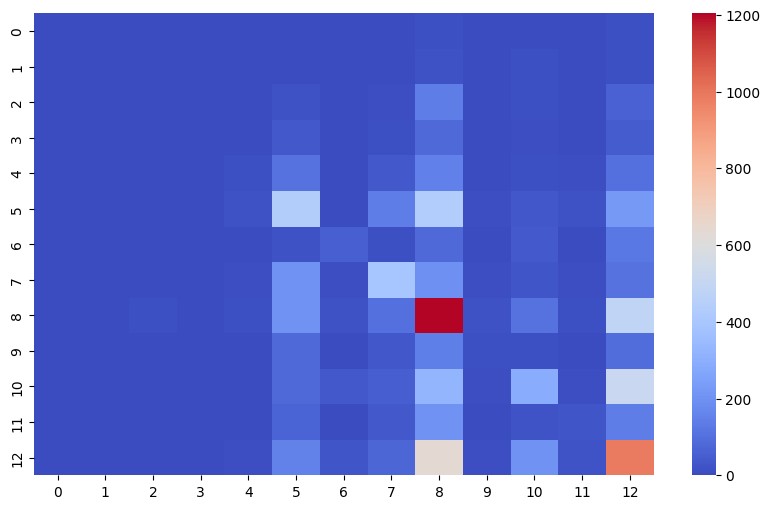

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_tf),cmap="coolwarm")

In [ ]:
y_prob = rf1.predict_proba(X_test)
metrics['Random Forest']['accuracy_score'] = round(accuracy_score(y_test, y_pred_tf),4)*100   # заполнение датафрейма с метриками
metrics['Random Forest']['time'] =   time_fit_1 # заполнение датафрейма с метриками
metrics['Random Forest']['roc_auc'] = round(roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro"),2)
metrics['Random Forest']['recall'] = round(recall_score(y_test, y_pred_tf, average="weighted"),4)*100
metrics['Random Forest']['precision'] = round(precision_score(y_test, y_pred_tf,  average="weighted"),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['Random Forest']

accuracy_score     34.22
time              177.95
roc_auc             0.66
recall             34.22
precision          31.76
Name: Random Forest, dtype: object

##Метод опорных векторов

> ```TfdifVectorizer```

In [ ]:
%%time

svm1 = Pipeline([('tfidf', TfidfVectorizer()), ('svm', svm.SVC())])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time,2)
y_pred_tf = svm1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = svm1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 74.56%
Test score: 35.35%
Time fit: 231.22 s
CPU times: user 5min 33s, sys: 229 ms, total: 5min 33s
Wall time: 5min 33s


Значение метрики точности у этой модели чуть больше, но по-прежнему низкое. Модель недообучена

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.33      0.00      0.01       235
           3       0.00      0.00      0.00       185
           4       0.17      0.00      0.00       431
           5       0.35      0.33      0.34      1304
           6       0.45      0.13      0.20       338
           7       0.48      0.39      0.43       946
           8       0.33      0.62      0.43      2158
           9       0.31      0.01      0.03       384
          10       0.41      0.16      0.23      1308
          11       0.45      0.02      0.04       503
          12       0.34      0.53      0.42      2108

    accuracy                           0.35      9966
   macro avg       0.28      0.17      0.16      9966
weighted avg       0.35      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

svm2 = Pipeline([('cv', CountVectorizer()),  ('svm', svm.SVC())])   # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time, 2)
y_pred_cv = svm2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = svm2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 67.86999999999999%
Test score: 35.54%
Time fit: 213.78 s
CPU times: user 5min 15s, sys: 236 ms, total: 5min 16s
Wall time: 5min 16s


```CountVectorizer``` показал результат лучше

In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.33      0.00      0.01       431
           5       0.32      0.35      0.34      1304
           6       0.52      0.14      0.22       338
           7       0.49      0.36      0.42       946
           8       0.34      0.63      0.44      2158
           9       0.25      0.01      0.02       384
          10       0.41      0.18      0.25      1308
          11       0.33      0.02      0.03       503
          12       0.34      0.52      0.41      2108

    accuracy                           0.36      9966
   macro avg       0.26      0.17      0.16      9966
weighted avg       0.35      0.36      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


```ContVectorizer``` показал результат выше

In [ ]:
metrics['SVM']['accuracy_score'] = round(accuracy_score(y_test, y_pred_cv),4)*100   # заполнение датафрейма с метриками
metrics['SVM']['time'] = time_fit_2
metrics['SVM']['recall'] = round(recall_score(y_test, y_pred_cv, average = 'weighted'),4)*100
metrics['SVM']['precision'] = round(precision_score(y_test, y_pred_cv, average = 'weighted'),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['SVM']

accuracy_score     35.54
time              213.78
roc_auc              NaN
recall             35.54
precision          34.74
Name: SVM, dtype: object

## Метод ближайших соседей

> ```TfdifVectorizer```

In [ ]:
%%time

kn1 = Pipeline([('tfidf', TfidfVectorizer()), ('knc', KNeighborsClassifier(n_neighbors = 10))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
kn1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time, 2)
y_pred_tf = kn1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = kn1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 24.349999999999998%
Test score: 22.79%
Time fit: 0.34 s
CPU times: user 3min 11s, sys: 117 ms, total: 3min 12s
Wall time: 1min 48s


Явно выраженное недообучение модели

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.06      0.01      0.01       235
           3       0.00      0.00      0.00       185
           4       0.18      0.00      0.01       431
           5       0.26      0.04      0.06      1304
           6       0.18      0.01      0.03       338
           7       0.45      0.10      0.17       946
           8       0.22      0.94      0.36      2158
           9       0.33      0.00      0.01       384
          10       0.39      0.03      0.06      1308
          11       0.33      0.00      0.00       503
          12       0.33      0.02      0.04      2108

    accuracy                           0.23      9966
   macro avg       0.21      0.09      0.06      9966
weighted avg       0.29      0.23      0.12      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

kn2 = Pipeline([('cv', CountVectorizer()), ('knc', KNeighborsClassifier(n_neighbors = 10))])  # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
kn2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time, 2)
y_pred_cv = kn2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = kn2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 34.050000000000004%
Test score: 26.97%
Time fit: 0.36 s
CPU times: user 26.4 s, sys: 11.4 s, total: 37.8 s
Wall time: 37.7 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.04      0.01      0.02       235
           3       0.17      0.01      0.01       185
           4       0.16      0.02      0.04       431
           5       0.25      0.12      0.17      1304
           6       0.32      0.10      0.15       338
           7       0.36      0.32      0.34       946
           8       0.25      0.80      0.38      2158
           9       0.23      0.01      0.02       384
          10       0.34      0.12      0.18      1308
          11       0.19      0.01      0.03       503
          12       0.31      0.13      0.18      2108

    accuracy                           0.27      9966
   macro avg       0.20      0.13      0.12      9966
weighted avg       0.27      0.27      0.21      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_prob = kn2.predict_proba(X_test)

metrics['Neighbors']['accuracy_score'] = round(accuracy_score(y_test, y_pred_cv),4)*100   # заполнение датафрейма с метриками
metrics['Neighbors']['time'] = time_fit_2   # заполнение датафрейма с метриками
metrics['Neighbors']['roc_auc'] = round(roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro"),2)
metrics['Neighbors']['recall'] = round(recall_score(y_test, y_pred_cv,average = 'weighted'),4)*100
metrics['Neighbors']['precision'] = round(precision_score(y_test, y_pred_cv,average = 'weighted'),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['Neighbors']

accuracy_score    26.97
time               0.36
roc_auc            0.58
recall            26.97
precision         27.35
Name: Neighbors, dtype: object

##Дерево решений

In [ ]:
%%time

tr1 = Pipeline([('tfidf', TfidfVectorizer()), ('tr', tree.DecisionTreeClassifier(max_depth = 45))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
tr1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time, 2)
y_pred_tf = tr1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = tr1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 49.85%
Test score: 29.880000000000003%
Time fit: 4.18 s
CPU times: user 4.57 s, sys: 8.15 ms, total: 4.58 s
Wall time: 4.57 s


Переобучение модели

In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.15      0.03      0.05       431
           5       0.27      0.28      0.27      1304
           6       0.39      0.14      0.20       338
           7       0.40      0.32      0.36       946
           8       0.29      0.72      0.42      2158
           9       0.14      0.03      0.05       384
          10       0.34      0.18      0.23      1308
          11       0.10      0.02      0.04       503
          12       0.32      0.21      0.25      2108

    accuracy                           0.30      9966
   macro avg       0.18      0.15      0.14      9966
weighted avg       0.28      0.30      0.26      9966



>```CountVectorizer```

In [ ]:
%%time

tr2 = Pipeline([('cv', CountVectorizer()),  ('tr', tree.DecisionTreeClassifier(max_depth = 60))])  # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
tr2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time, 2)
y_pred_cv = tr2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = tr2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 52.33%
Test score: 30.86%
Time fit: 4.79 s
CPU times: user 5.17 s, sys: 6.16 ms, total: 5.18 s
Wall time: 5.18 s


Модель недообучена

In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.06      0.01      0.01       185
           4       0.10      0.02      0.03       431
           5       0.27      0.32      0.29      1304
           6       0.36      0.13      0.19       338
           7       0.41      0.35      0.38       946
           8       0.31      0.67      0.42      2158
           9       0.11      0.03      0.04       384
          10       0.34      0.19      0.24      1308
          11       0.12      0.03      0.05       503
          12       0.32      0.27      0.29      2108

    accuracy                           0.31      9966
   macro avg       0.18      0.15      0.15      9966
weighted avg       0.28      0.31      0.27      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_prob = tr2.predict_proba(X_test)

metrics['Tree']['accuracy_score'] = round(accuracy_score(y_test, y_pred_cv),4)*100   # заполнение датафрейма с метриками
metrics['Tree']['time'] = time_fit_2   # заполнение датафрейма с метриками
metrics['Tree']['roc_auc'] = round(roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro"),2)
metrics['Tree']['recall'] = round(recall_score(y_test, y_pred_cv,average = 'weighted'),4)*100
metrics['Tree']['precision'] = round(precision_score(y_test, y_pred_cv,average = 'weighted'),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['Tree']

accuracy_score    30.86
time               4.79
roc_auc            0.58
recall            30.86
precision         28.21
Name: Tree, dtype: object

##Наивный байесовский классификатор ```MultinomialNB```

> ```TfidfVectorizer```

In [ ]:
%%time

nb1 = Pipeline([('tfidf', TfidfVectorizer()), ('nb', MultinomialNB(alpha = 0.2))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
nb1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time, 2)
y_pred_tf = nb1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = nb1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 60.79%
Test score: 30.43%
Time fit: 0.39 s
CPU times: user 786 ms, sys: 5.72 ms, total: 791 ms
Wall time: 795 ms


In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.00      0.00      0.00       431
           5       0.30      0.26      0.28      1304
           6       0.30      0.01      0.02       338
           7       0.44      0.24      0.31       946
           8       0.30      0.48      0.37      2158
           9       0.00      0.00      0.00       384
          10       0.29      0.14      0.19      1308
          11       0.08      0.00      0.00       503
          12       0.30      0.59      0.40      2108

    accuracy                           0.30      9966
   macro avg       0.15      0.13      0.12      9966
weighted avg       0.26      0.30      0.25      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

nb2 = Pipeline([('cv', CountVectorizer()),  ('nb', MultinomialNB(alpha = 0.2))]) # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
nb2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time, 2)
y_pred_cv = nb2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = nb2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 67.61%
Test score: 30.42%
Time fit: 0.35 s
CPU times: user 722 ms, sys: 3.88 ms, total: 726 ms
Wall time: 728 ms


In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.08      0.01      0.01       185
           4       0.08      0.03      0.04       431
           5       0.29      0.34      0.31      1304
           6       0.22      0.07      0.10       338
           7       0.38      0.38      0.38       946
           8       0.33      0.37      0.35      2158
           9       0.06      0.01      0.02       384
          10       0.27      0.26      0.27      1308
          11       0.11      0.04      0.05       503
          12       0.32      0.49      0.38      2108

    accuracy                           0.30      9966
   macro avg       0.16      0.15      0.15      9966
weighted avg       0.27      0.30      0.28      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_prob = nb1.predict_proba(X_test)

metrics['NB']['accuracy_score'] = round(accuracy_score(y_test, y_pred_tf),4)*100   # заполнение датафрейма с метриками
metrics['NB']['time'] = time_fit_1   # заполнение датафрейма с метриками
metrics['NB']['roc_auc'] = round(roc_auc_score(y_test, y_prob, multi_class="ovr",average="macro"),2)
metrics['NB']['recall'] = round(recall_score(y_test, y_pred_tf,average = 'weighted'),4)*100
metrics['NB']['precision'] = round(precision_score(y_test, y_pred_tf,average = 'weighted'),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['NB']

accuracy_score    30.43
time               0.39
roc_auc            0.64
recall            30.43
precision         26.12
Name: NB, dtype: object

##Пассивно -агрессивный классификатор

> ```TfidfVectorizer```

In [ ]:
%%time

pa1 = Pipeline([('tfidf', TfidfVectorizer()), ('pa', PassiveAggressiveClassifier(C = 0.00015))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
pa1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time, 2)
y_pred_tf = pa1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = pa1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 36.02%
Test score: 33.22%
Time fit: 3.49 s
CPU times: user 3.77 s, sys: 1.13 s, total: 4.9 s
Wall time: 3.94 s


In [ ]:
print(classification_report(y_test, y_pred_tf))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.00      0.00      0.00       235
           3       0.00      0.00      0.00       185
           4       0.00      0.00      0.00       431
           5       0.32      0.24      0.27      1304
           6       0.49      0.06      0.10       338
           7       0.46      0.37      0.41       946
           8       0.30      0.65      0.41      2158
           9       0.00      0.00      0.00       384
          10       0.43      0.11      0.17      1308
          11       0.00      0.00      0.00       503
          12       0.34      0.52      0.41      2108

    accuracy                           0.33      9966
   macro avg       0.18      0.15      0.14      9966
weighted avg       0.30      0.33      0.28      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


>```CountVectorizer```

In [ ]:
%%time

pa2 = Pipeline([('cv', CountVectorizer()),   ('pa', PassiveAggressiveClassifier(C = 0.000155))]) # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
pa2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time, 2)
y_pred_cv = pa2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_cv = pa2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_cv),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_cv),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 40.239999999999995%
Test score: 35.47%
Time fit: 3.86 s
CPU times: user 4.04 s, sys: 1.04 s, total: 5.08 s
Wall time: 4.22 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        40
           2       0.17      0.00      0.01       235
           3       0.00      0.00      0.00       185
           4       0.27      0.02      0.03       431
           5       0.32      0.36      0.34      1304
           6       0.44      0.16      0.23       338
           7       0.45      0.41      0.43       946
           8       0.34      0.62      0.44      2158
           9       0.33      0.00      0.01       384
          10       0.37      0.23      0.29      1308
          11       0.32      0.01      0.03       503
          12       0.35      0.46      0.40      2108

    accuracy                           0.35      9966
   macro avg       0.26      0.18      0.17      9966
weighted avg       0.34      0.35      0.31      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['Passive Agressive']['accuracy_score'] = round(accuracy_score(y_test, y_pred_cv),4)*100   # заполнение датафрейма с метриками
metrics['Passive Agressive']['time'] = time_fit_2  # заполнение датафрейма с метриками
metrics['Passive Agressive']['recall'] = round(recall_score(y_test, y_pred_cv,average = 'weighted'),4)*100
metrics['Passive Agressive']['precision'] = round(precision_score(y_test, y_pred_cv,average = 'weighted'),4)*100

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
metrics['Passive Agressive']

accuracy_score    35.47
time               3.86
roc_auc             NaN
recall            35.47
precision         34.12
Name: Passive Agressive, dtype: object

# Сравнение моделей

In [ ]:
metrics

,Logistic Regression,Random Forest,SVM,Neighbors,Tree,NB,Passive Agressive
accuracy_score,35.39,34.22,35.54,26.97,30.86,30.43,35.47
time,2.22,177.95,213.78,0.36,4.79,0.39,3.86
roc_auc,0.69,0.66,NaN,0.58,0.58,0.64,NaN
recall,35.39,34.22,35.54,26.97,30.86,30.43,35.47
precision,34.08,31.76,34.74,27.35,28.21,26.12,34.12


In [ ]:
metrics = metrics.drop(['time'], axis = 0)   # для тепловой матрицы, чтобы параметр сильно не выделялся
metrics

,Logistic Regression,Random Forest,SVM,Neighbors,Tree,NB,Passive Agressive
accuracy_score,35.39,34.22,35.54,26.97,30.86,30.43,35.47
roc_auc,0.69,0.66,NaN,0.58,0.58,0.64,NaN
recall,35.39,34.22,35.54,26.97,30.86,30.43,35.47
precision,34.08,31.76,34.74,27.35,28.21,26.12,34.12


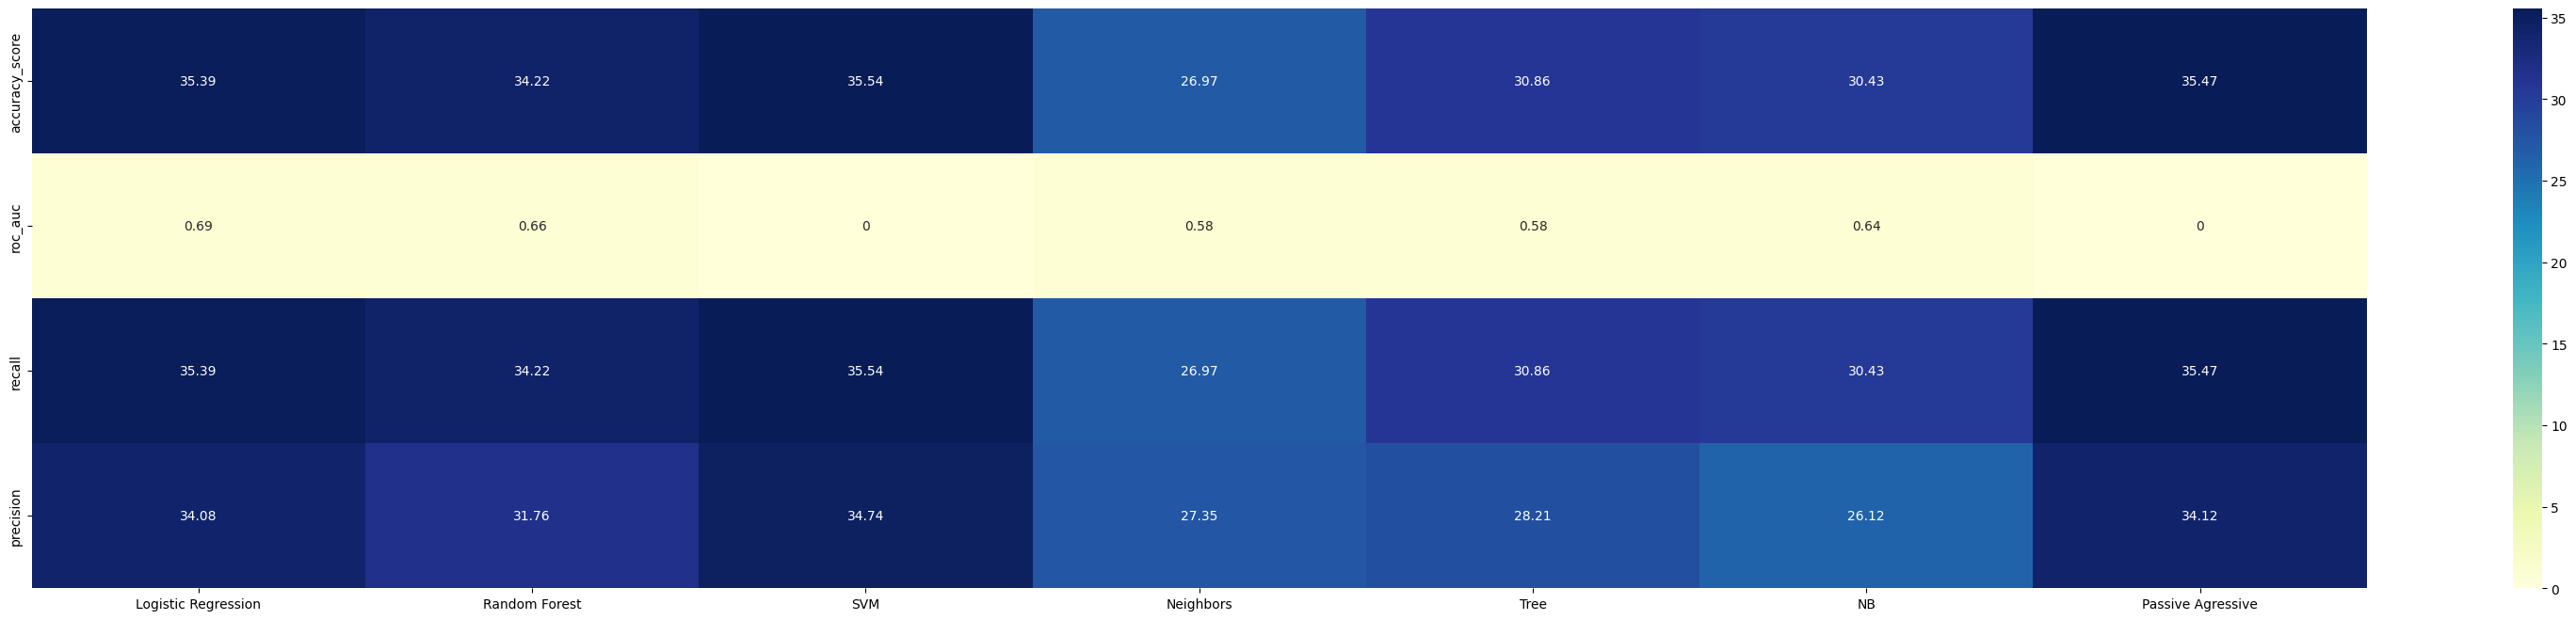

In [ ]:
fig, ax = plt.subplots(figsize = (40, 8))
sns.heatmap(metrics.fillna(0),  yticklabels = metrics.index, annot = True, fmt = '.6g', cmap = 'YlGnBu')
plt.show()

Наилучшие показатели точности у метода опорных векторов

# Улучшение модели

## Корректировка первоначальных данных

>Получились низкие показатели для всех моделей.\
Так как датасет несбалансированный и имеет много классов, сократим количество классов путем объелинения схожих и добавим еще один признак, показывающий положительная, нейтральная или отрицательная эмоция

In [ ]:
Y['sentiment'].value_counts()

neutral       8606
worry         8448
happiness     5183
sadness       5155
love          3787
surprise      2186
fun           1776
relief        1524
hate          1323
empty          826
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

Объединим классы ```anger```, ```hate``` в ```hate```\
Классы ```fun```, ```enthusiasm```,```happiness``` в ```happiness```\
Классы ```empty```,```boredom``` в ```boredom```\
Остальные оставим без измненения


In [ ]:
Y['sentiment'] = Y['sentiment'].replace('anger', 'hate')
Y['sentiment'] = Y['sentiment'].replace('fun', 'happiness')
Y['sentiment'] = Y['sentiment'].replace('enthusiasm', 'happiness')
Y['sentiment'] = Y['sentiment'].replace('empty', 'boredom')
len(Y['sentiment'].unique())

9

In [ ]:
Y['sentiment'].value_counts()

neutral      8606
worry        8448
happiness    7718
sadness      5155
love         3787
surprise     2186
relief       1524
hate         1433
boredom      1005
Name: sentiment, dtype: int64

Создадим еще один признак, описывающий характер эмоции (позитивная, негативная или нейтральная)

In [ ]:
X['emotion'] = Y['sentiment']
X['emotion'] = X['emotion'].replace('anger', 'negative')
X['emotion'] = X['emotion'].replace('boredom', 'negative')
X['emotion'] = X['emotion'].replace('empty', 'negative')
X['emotion'] = X['emotion'].replace('hate', 'negative')
X['emotion'] = X['emotion'].replace('sadness', 'negative')
X['emotion'] = X['emotion'].replace('worry', 'negative')
X['emotion'] = X['emotion'].replace('enthusiasm', 'positive')
X['emotion'] = X['emotion'].replace('relief', 'positive')
X['emotion'] = X['emotion'].replace('fun', 'positive')
X['emotion'] = X['emotion'].replace('surprise', 'positive')
X['emotion'] = X['emotion'].replace('love', 'positive')
X['emotion'] = X['emotion'].replace('happiness', 'positive')
X['emotion'].value_counts()

negative    16041
positive    15215
neutral      8606
Name: emotion, dtype: int64

In [ ]:
X.head()

,content,emotion
0,know listenin bad habit earlier started freakin =,negative
1,layin n bed headache ughhhh waitin call,negative
2,funeral ceremony gloomy friday,negative
3,want hang friend soon,positive
4,want trade houston ticket will,neutral


## Подготовка данных

In [ ]:
x1 = X['content'].values
x2 = X['emotion'].values
y = Y['sentiment'].values
x1, x2, y

(array(['know listenin bad habit earlier started freakin =',
        'layin n bed headache ughhhh waitin call',
        'funeral ceremony gloomy friday', ...,
        "happy mother 's day mommy there woman man long you 're 'momma ' day",
        'wassup beautiful follow me peep new hit single com/ipsohot def wat u video',
        'bullet train tokyo gf visiting japan thursday vacation/sightseeing gaijin godzilla'],
       dtype=object),
 array(['negative', 'negative', 'negative', ..., 'positive', 'positive',
        'positive'], dtype=object),
 array(['boredom', 'sadness', 'sadness', ..., 'love', 'happiness', 'love'],
       dtype=object))

In [ ]:
x = x1+' ' + x2
x

array(['know listenin bad habit earlier started freakin = negative',
       'layin n bed headache ughhhh waitin call negative',
       'funeral ceremony gloomy friday negative', ...,
       "happy mother 's day mommy there woman man long you 're 'momma ' day positive",
       'wassup beautiful follow me peep new hit single com/ipsohot def wat u video positive',
       'bullet train tokyo gf visiting japan thursday vacation/sightseeing gaijin godzilla positive'],
      dtype=object)

In [ ]:
dict_emotion = {i: np.unique(y)[i] for i in range(9)}
dict_emotion    # словарь соотношения категории и его номера

{0: 'boredom',
 1: 'happiness',
 2: 'hate',
 3: 'love',
 4: 'neutral',
 5: 'relief',
 6: 'sadness',
 7: 'surprise',
 8: 'worry'}

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)    # всевозможные уникальные значения переменной y
y, encoder.classes_   # всевозможные уникальные значения y

(array([0, 6, 6, ..., 3, 1, 3]),
 array(['boredom', 'happiness', 'hate', 'love', 'neutral', 'relief',
        'sadness', 'surprise', 'worry'], dtype=object))

In [ ]:
# произведем разбиение выборки на тестовую и обучающуюся

X_train, X_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.25, # проентная доля объема тестовой выборки от всего объема выборки
    random_state=42    # рандомное распределение данных по выборкам
    )

In [ ]:
X_train.shape, X_test.shape

((29896,), (9966,))

## Построение моделей

Посмотрим, как изменилась метрика при изменении данных

## Метод опорных векторов

При работе с первоначальными данными наиболее оптимальным оказался метод опорных векторов

In [ ]:
%%time

svm1 = Pipeline([('tfidf', TfidfVectorizer()), ('svm', svm.SVC())])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time,2)
y_pred_tf = svm1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = svm1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 87.06%
Test score: 65.68%
Time fit: 130.2 s
CPU times: user 3min 42s, sys: 194 ms, total: 3min 42s
Wall time: 3min 41s


In [ ]:
%%time

svm2 = Pipeline([('cv', CountVectorizer()), ('svm', svm.SVC())])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
svm2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time,2)
y_pred_tf = svm2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = svm2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 80.58999999999999%
Test score: 65.75999999999999%
Time fit: 77.66 s
CPU times: user 2min 43s, sys: 118 ms, total: 2min 44s
Wall time: 2min 43s


Показатели метрики точности зачительно улучшились\
Посмотрим другие метрики для ```CountVectorizer```

In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       364
           3       0.00      0.00      0.00       946
           4       0.23      0.00      0.01      2158
           5       0.06      0.23      0.09       384
           6       0.24      0.02      0.04      1308
           7       0.05      0.09      0.07       503
           8       0.17      0.32      0.23      2108
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0

    accuracy                           0.08      9966
   macro avg       0.06      0.05      0.03      9966
weighted avg       0.12      0.08      0.06      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_cv, labels = [j for j in range(9)])[i]
    for i in range(9)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'boredom': array([[9691,    0],
        [ 275,    0]]),
 'happiness': array([[8046,    0],
        [1920,    0]]),
 'hate': array([[9596,    6],
        [ 364,    0]]),
 'love': array([[9020,    0],
        [ 946,    0]]),
 'neutral': array([[7785,   23],
        [2151,    7]]),
 'relief': array([[8199, 1383],
        [ 297,   87]]),
 'sadness': array([[8567,   91],
        [1279,   29]]),
 'surprise': array([[8646,  817],
        [ 458,   45]]),
 'worry': array([[4659, 3199],
        [1432,  676]])}

<Axes: >

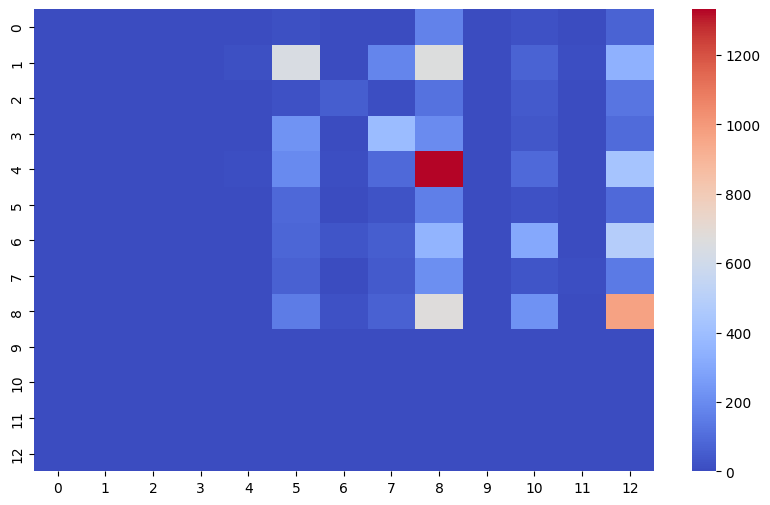

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_cv),cmap="coolwarm")

In [ ]:
print(f'Accuracy_score --> {round(accuracy_score(y_test, y_pred_cv),4)*100}')
print(f'Recall_score --> {round(recall_score(y_test, y_pred_cv, average="weighted"),4)*100}')
print(f'Precision_score --> {round(precision_score(y_test, y_pred_cv,  average="weighted"),4)*100}')   precision_score

Accuracy_score --> 8.469999999999999
Recall_score --> 8.469999999999999
Precision_score --> 12.41


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Пассивно-агрессивный классификатор

Модель ```PassiveAgressive``` показывала результаты, приближенные к методу опорных векторов, но несколько ниже. При этом время обучения было знаичтельно меньше

Для поиска наилучших параметров воспользуемся поиском по сетке

In [ ]:
params = {
      'pa__C': [0.01, 0.015, 0.001,0.0015]
  }

In [ ]:
grid = GridSearchCV(
    estimator = Pipeline([('cv', CountVectorizer()), ('pa', PassiveAggressiveClassifier())]),
    param_grid = params,
    cv = 4,
    scoring = 'accuracy'
)

In [ ]:
grid.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('pa', PassiveAggressiveClassifier())]),
             param_grid={'pa__C': [0.01, 0.015, 0.001, 0.0015]},
             scoring='accuracy')

In [ ]:
grid.best_params_

{'pa__C': 0.0015}

In [ ]:
%%time

pa2 = Pipeline([('cv', CountVectorizer()), ('pa', PassiveAggressiveClassifier(C = 0.0015))])    # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
pa2.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_2 = round(end_time - start_time,2)
y_pred_tf = pa2.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = pa2.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_2} s')

Training score: 69.38%
Test score: 64.66%
Time fit: 1.08 s
CPU times: user 1.52 s, sys: 449 ms, total: 1.97 s
Wall time: 1.5 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       364
           3       0.00      0.00      0.00       946
           4       0.23      0.00      0.01      2158
           5       0.06      0.23      0.09       384
           6       0.24      0.02      0.04      1308
           7       0.05      0.09      0.07       503
           8       0.17      0.32      0.23      2108
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0

    accuracy                           0.08      9966
   macro avg       0.06      0.05      0.03      9966
weighted avg       0.12      0.08      0.06      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_cv, labels = [j for j in range(9)])[i]
    for i in range(9)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'boredom': array([[9691,    0],
        [ 275,    0]]),
 'happiness': array([[8046,    0],
        [1920,    0]]),
 'hate': array([[9596,    6],
        [ 364,    0]]),
 'love': array([[9020,    0],
        [ 946,    0]]),
 'neutral': array([[7785,   23],
        [2151,    7]]),
 'relief': array([[8199, 1383],
        [ 297,   87]]),
 'sadness': array([[8567,   91],
        [1279,   29]]),
 'surprise': array([[8646,  817],
        [ 458,   45]]),
 'worry': array([[4659, 3199],
        [1432,  676]])}

<Axes: >

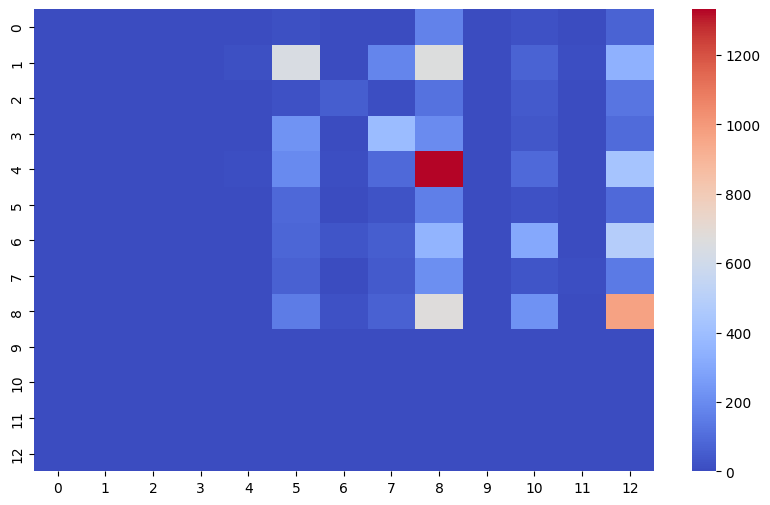

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_cv),cmap="coolwarm")

In [ ]:
print(f'Accuracy_score --> {round(accuracy_score(y_test, y_pred_cv),4)*100}')
print(f'Recall_score --> {round(recall_score(y_test, y_pred_cv, average="weighted"),4)*100}')
print(f'Precision_score --> {round(precision_score(y_test, y_pred_cv,  average="weighted"),4)*100}')

Accuracy_score --> 8.469999999999999
Recall_score --> 8.469999999999999
Precision_score --> 12.41


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Логистическая регрессия

Воспользуемся поиском по сетке для отыскания наилучших параметров

In [ ]:
params = {
      'lr__C': [0.25, 0.5,0.75,1,1.25],
      'lr__penalty': ['l1', 'l2'],
      'lr__solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag'],
  }

In [ ]:
grid = GridSearchCV(
    estimator = Pipeline([('cv', CountVectorizer()), ('lr', LogisticRegression())]),
    param_grid = params,
    cv = 4,
    scoring = 'accuracy'
)

In [ ]:
grid.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'lr__C': [0.25, 0.5, 0.75, 1, 1.25],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['lbfgs', 'liblinear', 'newton-cg',
                                        'sag']},
             scoring='accuracy')

In [ ]:
grid.best_params_

{'lr__C': 0.25, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}

Подставим полученные значения

In [ ]:
%%time

lr1 = Pipeline([('cv', CountVectorizer()), ('lr', LogisticRegression(C = 0.25, solver = 'liblinear', penalty = 'l1'))])     # последовательное применение методов из списка

start_time = time.time()    # для подсчета времени обучения модели
lr1.fit(X_train, y_train)    # обучение модели
end_time =time.time()
time_fit_1 = round(end_time - start_time,2)
y_pred_tf = lr1.predict(X_test)    # предсказание для тестовых данных
y_train_pred_tf = lr1.predict(X_train)   # предсказание обучающих данных
print(f"Training score: {round(accuracy_score(y_train, y_train_pred_tf),4)*100}%")   # метрика - показатель точности спрогнозированных данных,
                                                                                  # рассчитывается как отношение количества правильных прогнозов к их общему количеству.
print(f"Test score: {round(accuracy_score(y_test, y_pred_tf),4)*100}%")   # метрика точности спрогнозированных данных для тестовой выборки
print(f'Time fit: {time_fit_1} s')

Training score: 66.93%
Test score: 65.53%
Time fit: 6.46 s
CPU times: user 6.81 s, sys: 15.9 ms, total: 6.82 s
Wall time: 6.87 s


In [ ]:
print(classification_report(y_test, y_pred_cv))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       275
           1       0.00      0.00      0.00      1920
           2       0.00      0.00      0.00       364
           3       0.00      0.00      0.00       946
           4       0.23      0.00      0.01      2158
           5       0.06      0.23      0.09       384
           6       0.24      0.02      0.04      1308
           7       0.05      0.09      0.07       503
           8       0.17      0.32      0.23      2108
           9       0.00      0.00      0.00         0
          10       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          12       0.00      0.00      0.00         0

    accuracy                           0.08      9966
   macro avg       0.06      0.05      0.03      9966
weighted avg       0.12      0.08      0.06      9966



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

In [ ]:
conf_matrix1 = {
    dict_emotion[i]: multilabel_confusion_matrix(y_true = y_test, y_pred = y_pred_cv, labels = [j for j in range(9)])[i]
    for i in range(9)
}
conf_matrix1   #  матрица ошибок для каждого класса для мультиклассовой классификации

{'boredom': array([[9691,    0],
        [ 275,    0]]),
 'happiness': array([[8046,    0],
        [1920,    0]]),
 'hate': array([[9596,    6],
        [ 364,    0]]),
 'love': array([[9020,    0],
        [ 946,    0]]),
 'neutral': array([[7785,   23],
        [2151,    7]]),
 'relief': array([[8199, 1383],
        [ 297,   87]]),
 'sadness': array([[8567,   91],
        [1279,   29]]),
 'surprise': array([[8646,  817],
        [ 458,   45]]),
 'worry': array([[4659, 3199],
        [1432,  676]])}

<Axes: >

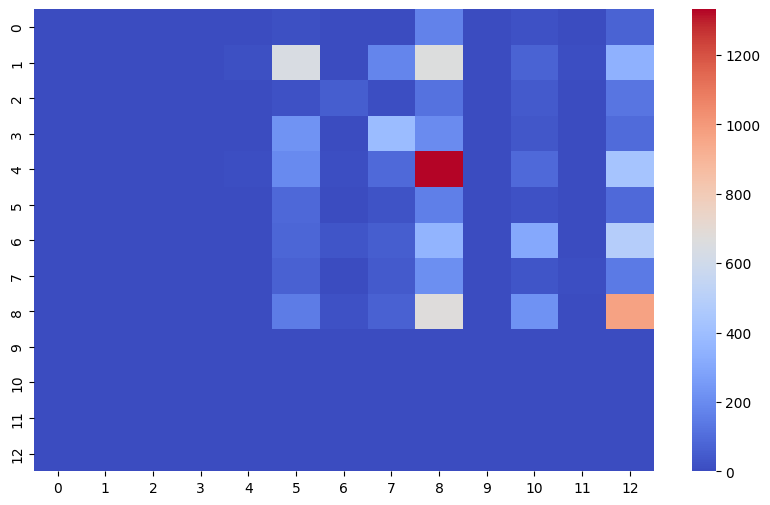

In [ ]:
plt.figure(figsize = (10,6))
sns.heatmap(confusion_matrix(y_test, y_pred_cv),cmap="coolwarm")

In [ ]:
print(f'Accuracy_score --> {round(accuracy_score(y_test, y_pred_cv),4)*100}')
print(f'Recall_score --> {round(recall_score(y_test, y_pred_cv, average="weighted"),4)*100}')
print(f'Precision_score --> {round(precision_score(y_test, y_pred_cv,  average="weighted"),4)*100}')

Accuracy_score --> 8.469999999999999
Recall_score --> 8.469999999999999
Precision_score --> 12.41


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Все модели показыают ~ одинаковые метрики точности. Наивысшая --$65.759%$ у **метода опорных ветокров**.

Проверим работу модели на примерах

In [ ]:
print(svm2.predict(['i hate you']))

[2]


In [ ]:
dict_emotion[2]

'hate'

In [ ]:
print(svm2.predict(['You are just incredible. I love you very much']))

[3]


In [ ]:
dict_emotion[3]

'love'

In [ ]:
print(svm2.predict(['We are very upset by yesterday s failed meeting. It was sad']))

[8]


In [ ]:
dict_emotion[8]

'worry'

# Заключение

При помощи инструментов машинного обучения удалось произвести классификацию текста первоначально на $13$ категорий эмоций. Самый высокий показатель точности предсказания составил $35$%, что является довольно низким результатом. Вследствие этого в ходе улучшения модели путем добавления дополнительного признака и объединения схожих по характеру классов удалось повыcить показатель точности до $65$%.

В ходе работы был проведен анализ исходного датасета и рассмотрены $7$ различных моделей классификации. Наилучшие показатели получились при использованиее метода опорных веторов.

На основе полученных результатов можно сделать вывод о том, что для классификации на $13$ различных классов в датасете имеется слишком малое количество строк и признаков, поскольку модель обучается долго и имеет низкие показатели.